Kleiner Tipp: über _< span style="color:red">  < span>_ kann der Text _<span style="color:red">rot kursiv_<span> geschrieben werden, wie es auf dem Aufgabenblatt gefordert wird (iwie bekloppt though). Vgl.: Please adress all questions and requirements wirtten below in _italics_ and <span style="color:red">red font<span style="color:black"> in your homework report.

### Question 1

_<span style="color:red">mean magnetization per site: $m[\phi]=\frac{\sinh(\beta h\pm\phi)}{\cosh(\beta \pm\phi)}=\tanh(\beta h\pm\phi)\Rightarrow\langle m[\phi]\rangle=\frac1{N_{cfg}}\sum_{\phi\in\{\phi\}}\tanh(\beta h\pm\phi)$_<span>
    
_<span style="color:red">mean energy per site: $\epsilon(\phi)=-\frac{\phi^2-3\beta}{3\beta^2}\frac1{2N}-h\tanh(\beta h\pm\phi)\Rightarrow\langle \epsilon[\phi]\rangle=-\frac1{N_{cfg}}\sum_{\phi\in\{\phi\}}\frac{\phi^2-3\beta}{3\beta^2}\frac1{2N_{cfg}}+h\tanh(\beta h\pm\phi)$_<span>

In [1]:
import numpy as np
from  math import *
import matplotlib.pyplot as plt
import scipy.optimize as so
import scipy.special as sp
import mpmath as mp

# was hat es mit dem p_0 auf sich? bzw kann man das nicht in eine globale Varibale verwandeln


# N_x=10
# N_y=10
# T=1
# J=0.5/T

N_md = 100 #Leapfrog integration steps
N_en = 1000
N_cfg = 2
beta=1
N=20
h=0.5
beta_h=0.5
J=1/N
phi_0 = 0
p_0 = 0 
I = 100
A = 15

In [2]:
def calc_magn(phi_en): 
    global beta_h
    global N_cfg
    global N_en
    global I
    global A
    
    M_array = np.zeros(N_en)
    M_array_I = np.zeros(int((N_en-I)/A))
    
    for i in range(N_en):
        phi_v = phi_en[i]
        M_array[i] = np.tanh(beta_h+phi_v) 
        
    M=0
    
    M_array_I = M_array[I::A]
    
    M=np.sum(M_array_I)
    
    return M/N_cfg

In [3]:
def calc_eps(phi_en): 
    global beta_h
    global h
    global beta
    global N_cfg
    
    e_array = np.zeros(N_en)
        
    for i in range(len(phi_en)):
        
        e_array[i]= (phi_en[i]**2-3*beta)/(3*beta**2)*1/(N_cfg)+h*mp.tanh(beta_h+phi_en[i])
    
    e = np.sum(e_array)
    
    return -e/N_cfg

In [4]:
def f():
    global beta_J
    global beta_h
    global N_cfg
    global x
    
    return(np.exp((beta_J*x**2)/2+beta_h*x))

In [5]:
def partition_func_theo():
    global beta_h
    global N_cfg
    global beta_J
    
    Z = 0
    
    for n in range(N_cfg+1):
        x = N_cfg-2*n
        Z += sp.binom(N_cfg, n)*f()
    
    return(Z)

In [6]:
def beta_eps_theo():
    global N_cfg
    global beta_J
    global beta_h
    
    value = 0
    
    for n in range(N_cfg+1):
        
        value += sp.binom(N_cfg, n)*(1/2*beta_J*(N_cfg-2*n)**2+beta_h*(N_cfg-2*n))*f(beta_J, beta_h, N_cfg-2*n)
    
    value = -value/(N_cfg*partition_func_theo())
    
    return(value)

In [7]:
def m_theo():
    global N_cfg
    global beta_J
    global beta_h
    
    value = 0
    
    for n in range(N_cfg+1):
        x = N_cfg-2*n
        value += sp.binom(N_cfg, n)*(N_cfg-2*n)*f()
        
    value = value/(N_cfg*partition_func_theo())
        
    return(value)

In [8]:
def leapfrog(p_0,phi_0):
    global beta 
    global J
    global N 
    global h
    global N_md
    
    eps=1/N_md
    phi=phi_0+eps/2*p_0
    p=p_0
    for i in range(N_md-1):
        p=p-eps*(phi/(beta*J)-N*mp.tanh(beta*h+phi))
        phi=phi+eps*p
    p=p-eps*(phi/(beta*J)-N*mp.tanh(beta*h+phi))
    phi=phi+eps/2*p
    
    return[p,phi]

In [9]:
def H(p,phi):
    global beta 
    global J 
    global h 
    
    return p**2/2+phi**2/(2*beta*J)-N*mp.log(2*mp.cosh(beta*h+phi))

In [10]:
def HMC(): #Does one iteration of the Markov-Chain and return phi
    global N_md
    global p_0
    global phi_0
    
    p = np.random.normal(loc=0.0, scale=1.0)
    phi_l = leapfrog(p_0,phi_0)[1]
    p_l =leapfrog(p_0,phi_0)[0]
    
    if np.exp(float(H(p,phi_0)-H(p_l,phi_l)))<1:
        P_acc = np.exp(H(p,phi_0)-H(p_l,phi_l))
    else:
        P_acc = 1
        
    if P_acc > np.random.rand(): 
        #p = p_l
        phi_0 = phi_l
        ar=+1
        
#    a_rate = ar/(N_x*N_y)*100
    
    return(phi_0, ar)

In [11]:
def ensemble(): #Generates an ensemble of phi and counts the acceptance rate
    global N_en
    global N_md
    global p_0
    global phi_0
    
    phi_en_calc =np.zeros(N_en)
    ar = 0
    
    for i in range(N_en):
        phi_en_calc[i] = HMC()[0]
    
    ar = ar/N_en*100
    
    return(phi_en_calc)

In [16]:
def m_J_5():  
#     global N_x
#     global N_y
    global h
    global N_cfg
    global beta_J
    
    E=20 #amount of points for the graph
    I=100 #initialization
    A=15 #autocorrelationcorrection
    C=1000 #Number of components for an ensemble
    D=4
    
    final_M=np.zeros(E+1) 
    M=0
    
    phi_en = ensemble()      # ist diese Zeile nicht doppelt und könnte damit einmal entfernt werden?
    colours=['b','g','r','c','m','y','k']    
    J_x = np.zeros(E+1)
    
    for m in range(D): #different lattice sizes      
        N_cfg=(m+1)*5
        final_M=np.zeros(E+1)
        
        for j in range(E+1): #Calculation for different J
            J=beta_J=0.2+(j/10)      # J=beta*J \in [0.2, 2.2)
            J_x[j]=J
            phi_en = ensemble()    
            final_M[j] = calc_magn(phi_en)
        plt.plot(J_x,final_M,color=colours[m+1],\
                 label='$N_{cfg}=$%s'%str((m+1)*4))
    plt.legend()
    plt.xlabel(r"$J$")
    plt.ylabel(r"$m(J)$")
    plt.show()

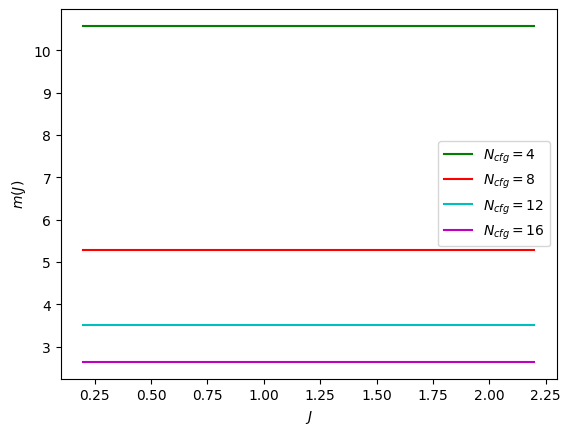

In [17]:
m_J_5()

In [22]:
def e_J_5():  
#     global N_x
#     global N_y
    global h
    global N_cfg
    global beta_J
    
    E=20 #amount of points for the graph
    I=100 #initialization
    A=15 #autocorrelationcorrection
    C=1000 #Number of components for an ensemble
    D=4
    
    final_eps=np.zeros(E+1) 
    M=0
    J_x = np.zeros(E+1)
    phi_en = ensemble()      # ist diese Zeile nicht doppelt und könnte damit einmal entfernt werden?
    colours=['b','g','r','c','m','y','k']    
    
    for m in range(D): #different lattice sizes      
        N_cfg=(m+1)*5
        final_M=np.zeros(E+1)
        
        for j in range(E+1): #Calculation for different J
            J=beta_J=0.2+(j/10)      # J=beta*J \in [0.2, 2.2)
            J_x[j]=J
            phi_en = ensemble()    
            final_eps[j] = calc_eps(phi_en)
        plt.plot(J_x,final_eps,color=colours[m+1],\
                 label='$N_{cfg}=$%s'%str((m+1)*4))
    plt.legend()
    plt.xlabel(r"$J$")
    plt.ylabel(r"$e(J)$")
    plt.show()

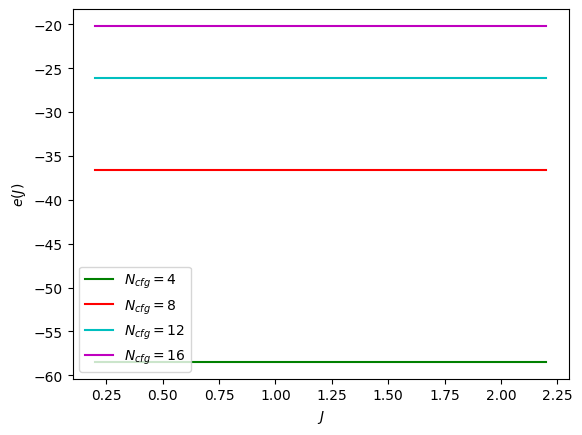

In [23]:
e_J_5()